In [1]:
from heron.data import DataWrapper

In [2]:
data = DataWrapper("/home/daniel/repositories/heron-training-data/data/v0d0d1.h5")

In [3]:
import numpy as np

In [4]:
def train(model, likelihood, iterations=100):# Find optimal model hyperparameters
    model.train()
    likelihood.train()
    #test_x = torch.tensor(x[1,59000::2], dtype=torch.float32)
    #test_y = torch.tensor(y[59000::2], dtype=torch.float32)
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=.5)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(iterations):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        string = f'Iter {i+1}/{iterations} - Loss: {loss.item():.3f} '
        if hasattr(model.covar_module.base_kernel, "kernels"):
            for kernel in model.covar_module.base_kernel.kernels:
                string += f" {1e7*kernel.lengthscale.item():.3f}E-7 "
        else:
            string += f" {model.covar_module.base_kernel.lengthscale.item():.3f} "
        string += f"noise: {model.likelihood.noise.item():.3f}"
        print(string)
        optimizer.step()

In [5]:
parameters, x, y = data.get_training_data("IMRPhenomPv2EqualMass")

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import torch
import gpytorch

In [25]:
train_x = torch.tensor(1000*x[1,60000::5], dtype=torch.float32)
ixs =[(train_x>-50)&(train_x<5)]
train_x = train_x[ixs]
train_y = torch.tensor(1e20*y[60000::5], dtype=torch.float32)
train_y = train_y[ixs]

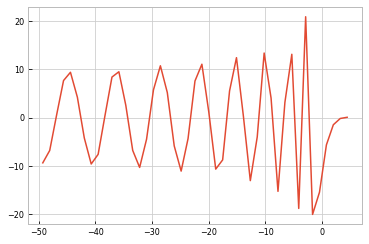

In [26]:
plt.plot(train_x, train_y)

In [27]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PiecewisePolynomialKernel(q=2))

In [43]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0, 0.0001))
model = ExactGPModel(train_x, train_y, likelihood)

In [40]:
train(model, likelihood, 40)

Iter 1/40 - Loss: 5.695  0.693 noise: 5.000
Iter 2/40 - Loss: 5.320  0.693 noise: 6.225
Iter 3/40 - Loss: 5.070  0.693 noise: 7.288
Iter 4/40 - Loss: 4.906  0.693 noise: 8.109
Iter 5/40 - Loss: 4.792  0.693 noise: 8.693
Iter 6/40 - Loss: 4.707  0.693 noise: 9.091
Iter 7/40 - Loss: 4.640  0.693 noise: 9.357
Iter 8/40 - Loss: 4.586  0.693 noise: 9.535
Iter 9/40 - Loss: 4.541  0.693 noise: 9.656
Iter 10/40 - Loss: 4.503  0.693 noise: 9.739
Iter 11/40 - Loss: 4.471  0.693 noise: 9.797
Iter 12/40 - Loss: 4.442  0.693 noise: 9.839
Iter 13/40 - Loss: 4.416  0.693 noise: 9.870
Iter 14/40 - Loss: 4.391  0.693 noise: 9.893
Iter 15/40 - Loss: 4.367  0.693 noise: 9.911
Iter 16/40 - Loss: 4.345  0.693 noise: 9.924
Iter 17/40 - Loss: 4.323  0.693 noise: 9.935
Iter 18/40 - Loss: 4.303  0.693 noise: 9.943
Iter 19/40 - Loss: 4.285  0.693 noise: 9.950
Iter 20/40 - Loss: 4.268  0.693 noise: 9.955
Iter 21/40 - Loss: 4.252  0.693 noise: 9.960
Iter 22/40 - Loss: 4.236  0.693 noise: 9.963
Iter 23/40 - Loss: 

In [41]:
model.eval()
likelihood.eval()

test_x = torch.tensor(1000*x[1,63000::], dtype=torch.float32)

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
#f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

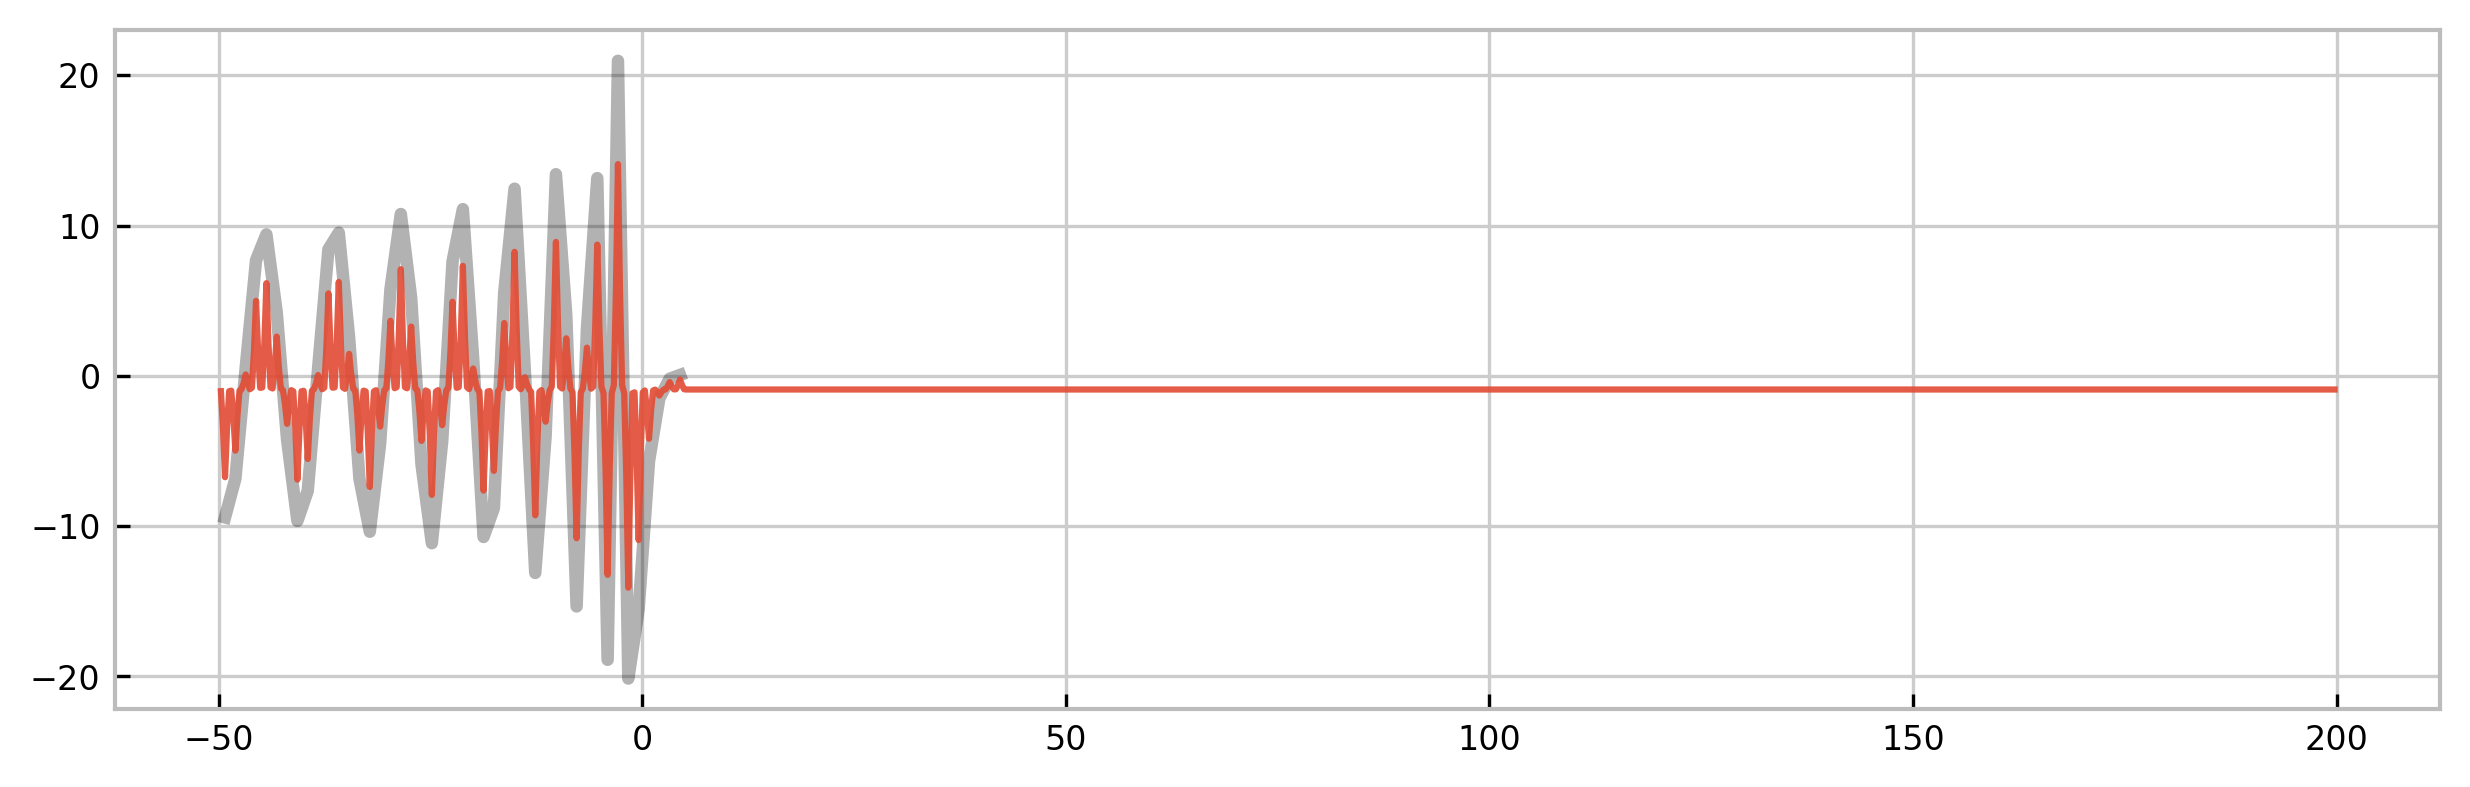

In [42]:
f, ax = plt.subplots(1,1, dpi=300, figsize=(10,3))
ax.plot(train_x[train_x>-50], train_y.detach().numpy()[train_x>-50], 'k', lw=3, alpha=0.3)
ax.plot(test_x[test_x>-50], f_mean.detach().numpy()[test_x>-50], alpha=0.9)